
[流程日志] 步骤 1：数据加载
  -> 数据读取成功，样本量：374，特征数：13
   Person ID Gender  Age         Occupation  Sleep Duration  Quality of Sleep  \
0          1   Male   27  Software Engineer             6.1                 6   
1          2   Male   28             Doctor             6.2                 6   
2          3   Male   28             Doctor             6.2                 6   

   Physical Activity Level  Stress Level BMI Category Blood Pressure  \
0                       42             6   Overweight         126/83   
1                       60             8       Normal         125/80   
2                       60             8       Normal         125/80   

   Heart Rate  Daily Steps Sleep Disorder  
0          77         4200            NaN  
1          75        10000            NaN  
2          75        10000            NaN  

[流程日志] 步骤 2：数据清洗与特征工程
  -> 数据清洗与特征工程完成

[流程日志] 步骤 3：探索性数据分析可视化
  -> EDA 可视化图表已保存至本地目录

[流程日志] 步骤 4：模型训练、调参与性能评估
  -> 训练集规模: (261, 21), 测试集规模: (113, 21)

=== 决策树 模型评

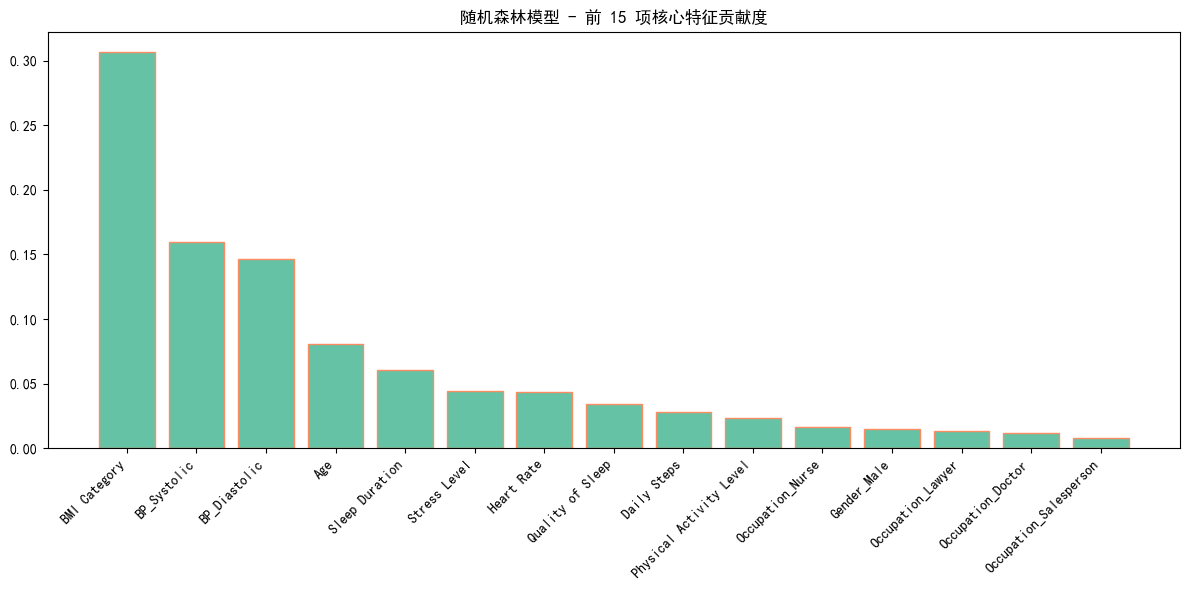

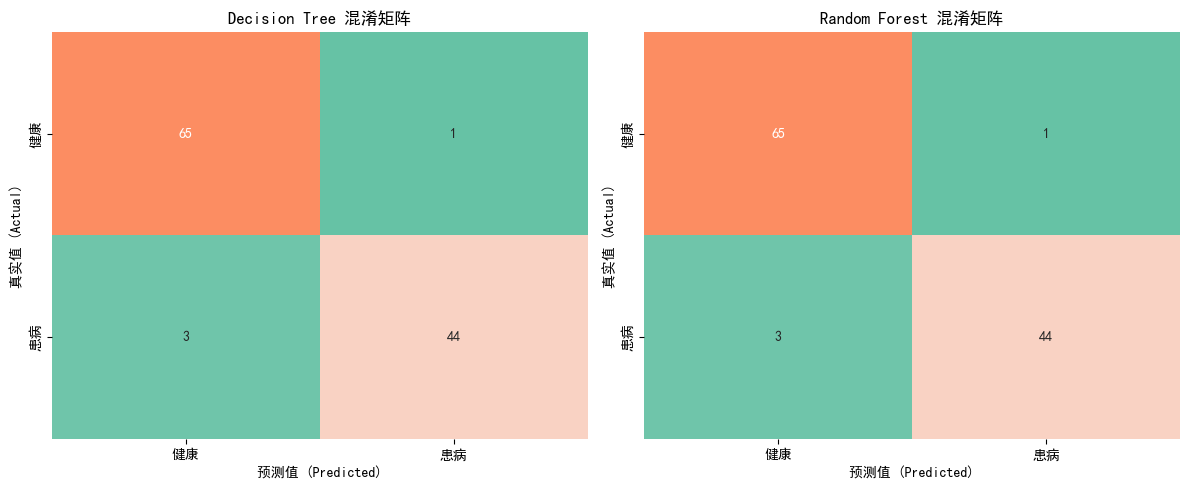

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from matplotlib.colors import LinearSegmentedColormap

# 机器学习库：用于模型训练、参数优化和指标评估 [cite: 11, 13]
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 忽略警告信息，保持输出界面整洁
warnings.filterwarnings('ignore')

# ---------------- 环境配置 ----------------
# 配置中文字体，确保在不同操作系统下可视化图表的中文标签能正常显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示为方块的问题

# 定义统一的视觉风格（配色方案）
COLOR_PALETTE = ["#66c2a5", "#fc8d62"]
CMAP_CUSTOM = LinearSegmentedColormap.from_list(
    "custom_div", ["#66c2a5", "#f7f7f7", "#fc8d62"]
)

# ---------------- 主处理类 ----------------
class SleepStudyAdvanced:
    """
    睡眠健康数据分析类：集成数据加载、清洗、可视化与机器学习建模 [cite: 5]
    符合面向对象编程（OOP）要求，提高代码的可维护性与模块化 [cite: 12]
    """

    def __init__(self, work_dir, filename):
        """
        初始化项目路径与参数
        :param work_dir: 结果输出与数据存储的文件夹路径
        :param filename: 数据集文件名
        """
        self.work_dir = work_dir
        self.file_path = os.path.join(work_dir, filename)
        self.df = None
        self.encoded_cols = [] # 用于存储经过One-Hot编码后新生成的列名

        # 异常处理：自动创建不存在的输出目录 [cite: 5]
        if not os.path.exists(work_dir):
            os.makedirs(work_dir)

    def log(self, msg):
        """统一的流程日志打印函数 [cite: 12]"""
        print(f"[流程日志] {msg}")

    # ---------- 1. 数据加载模块 ----------
    def load_data(self):
        """
        加载原始CSV数据集
        包含文件存在性检查的异常防御逻辑 [cite: 5]
        """
        print("\n" + "=" * 50)
        self.log("步骤 1：数据加载")

        if not os.path.exists(self.file_path):
            print(f"  -> [错误] 文件未找到: {self.file_path}")
            return False

        self.df = pd.read_csv(self.file_path)
        print(f"  -> 数据读取成功，样本量：{self.df.shape[0]}，特征数：{self.df.shape[1]}")
        print(self.df.head(3))
        return True

    # ---------- 2. 数据清洗与特征工程模块 ----------
    def check_and_clean_data(self):
        """
        执行探索性数据分析(EDA)前的数据预处理 [cite: 10]
        包含：缺失值填充、异常值剔除、数据类型转换与特征提取
        """
        print("\n" + "=" * 50)
        self.log("步骤 2：数据清洗与特征工程")

        # ---- 2.1 缺失值自动化处理 ----
        # 逻辑：分类变量填众数，数值变量填中位数，目标变量特殊标注 [cite: 10]
        for col in self.df.columns:
            if self.df[col].isnull().sum() > 0:
                if col == 'Sleep Disorder':
                    self.df[col] = self.df[col].fillna('None')
                elif self.df[col].dtype == 'object':
                    self.df[col] = self.df[col].fillna(self.df[col].mode()[0])
                else:
                    self.df[col] = self.df[col].fillna(self.df[col].median())

        # ---- 2.2 数据质量控制：心率异常值剔除 ----
        # 根据生理常识，筛选心率在 40-200 之间的合理区间样本
        self.df = self.df[
            (self.df['Heart Rate'] >= 40) & 
            (self.df['Heart Rate'] <= 200)
        ]

        # ---- 2.3 字符串解析：血压特征拆分 ----
        # 使用 try-except 捕获可能的数据格式转换异常 [cite: 5, 12]
        try:
            # 将 '120/80' 格式拆分为 收缩压(Systolic) 和 舒张压(Diastolic)
            self.df[['BP_Systolic', 'BP_Diastolic']] = (
                self.df['Blood Pressure']
                .str.split('/', expand=True)
                .astype(int)
            )
            self.df.drop(columns=['Blood Pressure'], inplace=True)
        except Exception as e:
            print(f"  -> [警告] 血压列解析失败，请检查数据格式: {e}")

        # ---- 2.4 BMI 有序分类变量编码 ----
        # 将文本等级转换为数值，以便模型理解其程度（Normal < Overweight < Obese）
        bmi_map = {
            'Normal': 0,
            'Normal Weight': 0,
            'Overweight': 1,
            'Obese': 2
        }
        self.df['BMI Category'] = self.df['BMI Category'].map(bmi_map).fillna(0)

        # ---- 2.5 构建二分类目标变量 ----
        # 0 代表健康(None)，1 代表患有睡眠障碍 
        self.df['Has_Disorder'] = self.df['Sleep Disorder'].apply(
            lambda x: 0 if x == 'None' else 1
        )

        # ---- 2.6 分类特征独热编码 (One-Hot Encoding) ----
        # 处理性别、职业等无序分类特征，drop_first=True 用于避免多重共线性
        original_cols = self.df.columns.tolist()
        self.df = pd.get_dummies(
            self.df, 
            columns=['Gender', 'Occupation'], 
            drop_first=True
        )
        # 记录新生成的哑变量列名
        self.encoded_cols = [c for c in self.df.columns if c not in original_cols and c not in ['BP_Systolic', 'BP_Diastolic']]

        print("  -> 数据清洗与特征工程完成")

    # ---------- 3. 探索性数据分析 (EDA) 可视化 ----------
    def perform_visualization(self):
        """
        利用 matplotlib 和 seaborn 进行数据可视化展示 [cite: 5, 10]
        """
        print("\n" + "=" * 50)
        self.log("步骤 3：探索性数据分析可视化")

        # 可视化 1：相关性热力图（排除独热编码列以保证画面清晰）
        core_features = [
            'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
            'Stress Level', 'BMI Category', 'Heart Rate', 'Daily Steps', 
            'BP_Systolic', 'BP_Diastolic', 'Has_Disorder'
        ]
        plot_cols = [c for c in core_features if c in self.df.columns]

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            self.df[plot_cols].corr(),
            cmap=CMAP_CUSTOM,
            annot=True, # 显示具体系数
            fmt=".2f",
            center=0
        )
        plt.xticks(rotation=45)
        plt.title("特征相关性矩阵 (核心指标)")
        plt.tight_layout()
        plt.savefig(os.path.join(self.work_dir, "111_correlation.png"), dpi=300)

        # 可视化 2：压力等级与睡眠障碍分布图
        plt.figure(figsize=(8, 6))
        sns.countplot(
            x='Stress Level', 
            hue='Has_Disorder', 
            data=self.df, 
            palette=COLOR_PALETTE
        )
        plt.title("压力等级与睡眠障碍关系分布")
        plt.xlabel("压力等级")
        plt.ylabel("人数计数")
        plt.legend(title='健康状态', labels=['正常', '睡眠障碍'])
        plt.tight_layout()
        plt.savefig(os.path.join(self.work_dir, "222_stress_vs_disorder.png"), dpi=300)
        plt.close('all')

        print("  -> EDA 可视化图表已保存至本地目录")

    # ---------- 4. 机器学习建模与评估 ----------
    def run_models(self):
        """
        使用决策树和随机森林算法进行建模对比，并进行超参数调优 
        """
        print("\n" + "=" * 50)
        self.log("步骤 4：模型训练、调参与性能评估")

        # 准备特征矩阵 X 和目标向量 y
        drop_cols = ['Person ID', 'Sleep Disorder', 'Has_Disorder']
        X = self.df.drop(columns=[c for c in drop_cols if c in self.df.columns])
        y = self.df['Has_Disorder']

        # 划分训练集与测试集，使用 stratify 保证类别比例平衡 
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=0.3, 
            random_state=42, 
            stratify=y 
        )

        print(f"  -> 训练集规模: {X_train.shape}, 测试集规模: {X_test.shape}")

        # ---- 算法 1：决策树 (Decision Tree) + 网格搜索调参 ----
        dt_param_grid = {'max_depth': [3, 5, 8], 'criterion': ['gini', 'entropy']}
        dt = GridSearchCV(
            DecisionTreeClassifier(random_state=42),
            param_grid=dt_param_grid,
            cv=5 # 5折交叉验证 
        )
        dt.fit(X_train, y_train)

        # ---- 算法 2：随机森林 (Random Forest) + 网格搜索调参 ----
        rf_param_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10]}
        rf = GridSearchCV(
            RandomForestClassifier(random_state=42),
            param_grid=rf_param_grid,
            cv=5
        )
        rf.fit(X_train, y_train)

        # 打印模型对比结果 
        for name, model in zip(['决策树', '随机森林'], [dt, rf]):
            y_pred = model.predict(X_test)
            print(f"\n=== {name} 模型评估 ===")
            print(f"最优参数: {model.best_params_}")
            print(f"测试集准确率: {accuracy_score(y_test, y_pred):.4f}")

        # 可视化 3：随机森林特征重要性排序
        best_rf = rf.best_estimator_
        importances = best_rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        top_n = 15
        top_indices = indices[:top_n]

        plt.figure(figsize=(12, 6))
        plt.bar(range(len(top_indices)), importances[top_indices], color="#66c2a5", edgecolor="#fc8d62")
        plt.xticks(range(len(top_indices)), X.columns[top_indices], rotation=45, ha='right')
        plt.title(f"随机森林模型 - 前 {top_n} 项核心特征贡献度")
        plt.tight_layout()
        plt.savefig(os.path.join(self.work_dir, "333_feature_importance.png"), dpi=300)

        # 调用混淆矩阵绘制函数进行对比 [cite: 12, 13]
        self.plot_confusion_matrices(y_test, dt, rf, X_test)

        print("  -> 模型对比分析完成")

    def plot_confusion_matrices(self, y_test, model1, model2, X_test):
        """
        绘制两种算法的混淆矩阵对比图 
        """
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        for ax, model, name in zip(axes, [model1, model2], ['Decision Tree', 'Random Forest']):
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap=CMAP_CUSTOM, ax=ax, cbar=False)
            
            ax.set_title(f'{name} 混淆矩阵')
            ax.set_xlabel('预测值 (Predicted)')
            ax.set_ylabel('真实值 (Actual)')
            ax.set_xticklabels(['健康', '患病'])
            ax.set_yticklabels(['健康', '患病'])
            
        plt.tight_layout()
        plt.savefig(os.path.join(self.work_dir, '444_model_comparison.png'), dpi=300)
        print("  -> 图表已保存: 444_model_comparison.png")

# ---------------- 程序主入口 ----------------
if __name__ == "__main__":
    # 配置本地文件路径与数据集名称 [cite: 9]
    # 注意：请确保数据集已放置在该路径下
    USER_PATH = r"C:\Users\17616\Desktop\PythonFinal"
    FILE_NAME = "Sleep_health_and_lifestyle_dataset.csv"

    # 实例化分析对象 [cite: 5]
    app = SleepStudyAdvanced(USER_PATH, FILE_NAME)

    # 按照作业流程顺序调用方法 
    if not app.load_data():
        print("程序终止：未找到必要的输入数据文件。")
    else:
        app.check_and_clean_data()   # 数据清洗 [cite: 10]
        app.perform_visualization()  # 探索性可视化 [cite: 10]
        app.run_models()             # 建模与评估 

    print("\n" + "=" * 50)
    print("所有分析任务已圆满完成。")